## SVDpp
---
Surprise algorithm: SVD(biased=True, n_epochs = 100)

Hyperparameter: 
1. Threshold when do the recommendation
2. n_factors in SVD 
3. lambda (regularization term)
4. gamma (learning rate)
Things to do:
1. Calculate test loss
2. Do the recommendations (done)
3. Calculate precision, recall, f1

In [1]:
import numpy as np
import pandas as pd
import json
import numpy as np
import scipy.sparse as sp
import time
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)

from surprise import SVDpp
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')

import preprocess
import evaluation

In [2]:
random_dict = preprocess.create_random_subset_paper_paper_data(debug=True)
traindict, testdict = preprocess.create_train_test_dic(random_dict)

trainset = preprocess.create_surprise_paper_paper_data(traindict).build_full_trainset()
testset  = preprocess.create_surprise_paper_paper_data(testdict).build_full_trainset().build_testset()

In [3]:
algo = SVDpp(biased=False,n_epochs = 100)
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [4]:
df[0:10]

,uid,iid,rui,est,details
0,9753c508-20e1-4f9b-baf4-f0c49008dcbc,d578fe46-9b3d-4425-8e2b-a2aac2170b06,1.0,-1.360096,{'was_impossible': False}
1,f1dede99-ff4e-4e9a-8950-2f91c9c02f6a,5e7b1c2c-baaf-466d-be01-c075002bf1fb,1.0,-0.146043,{'was_impossible': False}
2,f1dede99-ff4e-4e9a-8950-2f91c9c02f6a,e8cbffc8-d292-4d4b-ae22-f96c645e4461,1.0,-1.138955,{'was_impossible': False}
3,ed43ebb5-f6c4-4a3e-9ea3-8e5c17de7178,8188df0c-955f-4fef-961d-c67ae2ee3799,1.0,-0.908665,{'was_impossible': False}
4,5d98c64a-c521-41f7-95f9-eb07a4c40196,f967618b-e047-43a9-bea8-44b9e74d708f,1.0,-1.243419,{'was_impossible': False}
5,2ced1d5a-a5ff-4860-99d2-9832b11b1f40,978efa8a-b62a-4e76-a2a1-c3a7af5e1a60,1.0,-1.925202,{'was_impossible': False}
6,c59e69d0-32bb-416c-aed2-3211aa5ceb30,71f4c930-83fe-4cf2-b895-264d716e02b2,1.0,-0.732066,{'was_impossible': False}
7,b2336fd0-40a2-4c1f-9c4b-fcbfd5c68ac4,d35738a8-0c5f-4788-bbcc-ef55a504be78,1.0,-0.798970,{'was_impossible': False}
8,c4161e2c-84c1-4b71-a63a-33230f5ebce9,70f4dcf0-2784-4627-899c-1463988a3f52,1.0,-0.551951,{'was_impossible': False}
9,d9194ae3-7fa8-4c1c-a681-d1bac8050fa7,3662e5bc-d634-43c2-90fe-f18ebd3033f4,1.0,-1.138151,{'was_impossible': False}


In [7]:
accuracy.rmse(predictions)
trainestdata = trainset.build_testset()
# trainpredictions = algo.test(trainestdata, clip=False)

RMSE: 1.9284


In [8]:
factors_to_try = [5,10,50,100,300,500,1000]
rmse_train = np.zeros(len(factors_to_try))
rmse_test = np.zeros(len(factors_to_try))
elapsed_time = np.zeros(len(factors_to_try))
for i in range(len(factors_to_try)):
    nfactors = factors_to_try[i]
    
    t = time.time()
    algo = SVDpp(biased=False, n_epochs = 300, n_factors = nfactors)
    algo.fit(trainset)
    elapsed_time[i] = time.time() - t
    
    testpredictions  = algo.test(testset, clip=False)
    trainpredictions = algo.test(trainestdata, clip=False)
    
    rmse_train[i] = accuracy.rmse(trainpredictions)
    rmse_test[i]  = accuracy.rmse(testpredictions)
    print(rmse_train[i], rmse_test[i], 'time = ', elapsed_time[i])

RMSE: 0.0183
RMSE: 2.1279
0.0183239033842 2.12790849692 time =  5.34440493584
RMSE: 0.0171
RMSE: 1.9883
0.017057599895 1.98831179128 time =  5.56270384789
RMSE: 0.0156
RMSE: 1.9544
0.0155868554128 1.95442749895 time =  7.84667181969
RMSE: 0.0144
RMSE: 1.9229
0.0143789901929 1.92292373917 time =  11.0643761158
RMSE: 0.0104
RMSE: 1.9562
0.0103853085559 1.95620745629 time =  39.8279678822
RMSE: 0.0083
RMSE: 1.9486
0.00833752217621 1.94862533826 time =  53.5066559315
RMSE: 0.0060
RMSE: 2.0272
0.00602359254547 2.02719576138 time =  110.745985985


Text(0,0.5,'seconds')

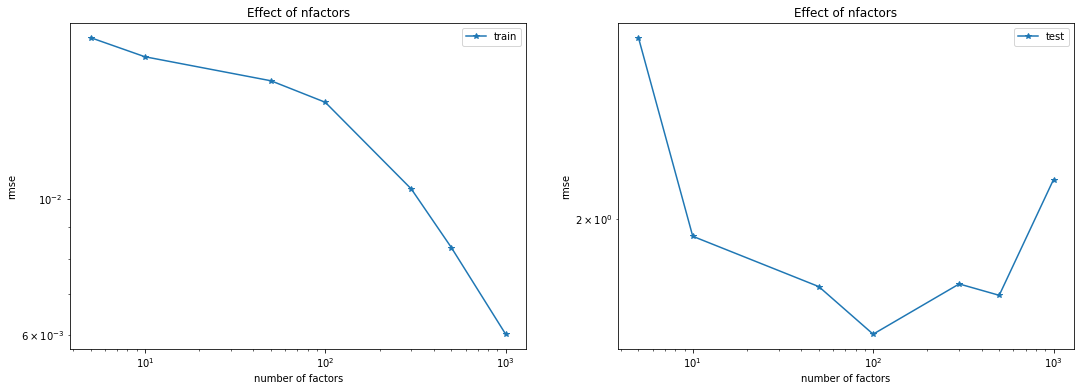

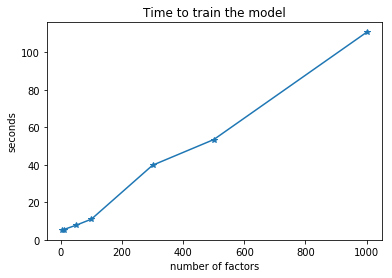

In [9]:
fig, axes = plt.subplots(1,2,figsize=(18,6))

# axes[0].plot(factors_to_try, rmse_train, '-*', label="train")
axes[0].loglog(factors_to_try, rmse_train, '-*', label="train")
axes[0].set_title('Effect of nfactors')
axes[0].set_xlabel('number of factors')
axes[0].set_ylabel('rmse')
axes[0].legend()

axes[1].loglog(factors_to_try, rmse_test, '-*', label="test")
axes[1].set_title('Effect of nfactors')
axes[1].set_xlabel('number of factors')
axes[1].set_ylabel('rmse')
axes[1].legend()

fig, axes = plt.subplots(figsize=(6,4))
axes.plot(factors_to_try, elapsed_time, '-*')
axes.set_title('Time to train the model')
axes.set_xlabel('number of factors')
axes.set_ylabel('seconds')

### lambda

In [10]:
nfactors = 100
reg_lambdas = 10**np.linspace(-3,2,6)
rmse_train = np.zeros(len(reg_lambdas))
rmse_test  = np.zeros(len(reg_lambdas))
elapsed_time = np.zeros(len(reg_lambdas))
for i in range(len(reg_lambdas)):
    reg_lambda = reg_lambdas[i]
    
    t = time.time()
    algo = SVDpp(biased=False,n_epochs = 500, n_factors = nfactors, reg_all=reg_lambda)
    algo.fit(trainset)
    elapsed_time[i] = time.time() - t
    
    testpredictions  = algo.test(testset, clip=False)
    trainpredictions = algo.test(trainestdata, clip=False)
    
    rmse_train[i] = accuracy.rmse(trainpredictions)
    rmse_test[i]  = accuracy.rmse(testpredictions)
    print(reg_lambda,rmse_train[i], rmse_test[i], 'time = ', elapsed_time[i])

RMSE: 0.0007
RMSE: 1.9216
0.001 0.000731746429199 1.92164099889 time =  19.1445131302
RMSE: 0.0072
RMSE: 1.9296
0.01 0.00719400801409 1.92964219787 time =  18.459084034
RMSE: 0.0718
RMSE: 1.9311
0.1 0.0718286098495 1.93111874634 time =  18.9989361763
RMSE: 0.7082
RMSE: 1.8886
1.0 0.70819865457 1.88860833619 time =  19.4024078846
RMSE: 2.0000
RMSE: 2.0000
10.0 2.0 2.0 time =  18.3900151253
RMSE: 2.0000
RMSE: 2.0000
100.0 2.0 2.0 time =  18.6166059971


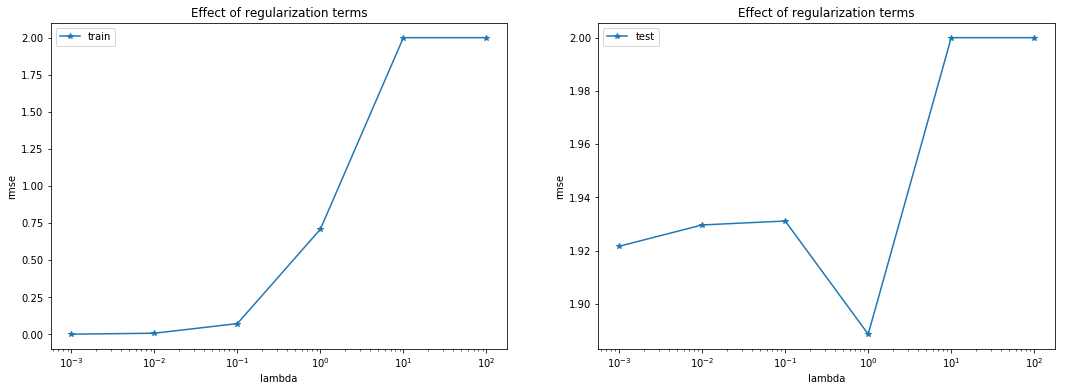

In [12]:
fig, axes = plt.subplots(1,2,figsize=(18,6))

# axes[0].plot(factors_to_try, rmse_train, '-*', label="train")
axes[0].semilogx(reg_lambdas, rmse_train, '-*', label="train")
axes[0].set_title('Effect of regularization terms')
axes[0].set_xlabel('lambda')
axes[0].set_ylabel('rmse')
axes[0].legend()

axes[1].semilogx(reg_lambdas, rmse_test, '-*', label="test")
axes[1].set_title('Effect of regularization terms')
axes[1].set_xlabel('lambda')
axes[1].set_ylabel('rmse')
axes[1].legend()

## Reasons that this method doesn't work

All the ratings are 1. If we are minimizing RMSE, the algorithms will end with p = q = 0, which will give us prediction = pu = global_mean = 1.

In [ ]:
algo = SVDpp(biased=False, n_epochs = 500, n_factors = 50, reg_all=100)
algo.fit(trainset)

In [ ]:
algo.pu

In [ ]:
algo.qi

## Precision and Recall

In [13]:
algo = SVDpp(biased=False, n_epochs = 300, n_factors = 100, reg_all=1)
algo.fit(trainset)

user_ids = list(testdict.keys())
user_est_true = evaluation.prediction_for_userids(algo, trainset, testdict, user_ids)

In [14]:
thresholds = np.linspace(-3,3,100)
precision = np.zeros(len(thresholds))
recall = np.zeros(len(thresholds))
f1 = np.zeros(len(thresholds))

for t,threshold in enumerate(thresholds):
    precisions, recalls = evaluation.precision_recall_at_k(user_est_true, testdict, k=10, threshold=threshold)
    precision[t] = sum(prec for prec in precisions.values()) / len(precisions)
    recall[t] = sum(rec for rec in recalls.values()) / len(recalls)
    f1[t] = 2*(precision[t]*recall[t])/(precision[t]+recall[t])
#     print(precision[t], recall[t])

Text(0,0.5,'precision')

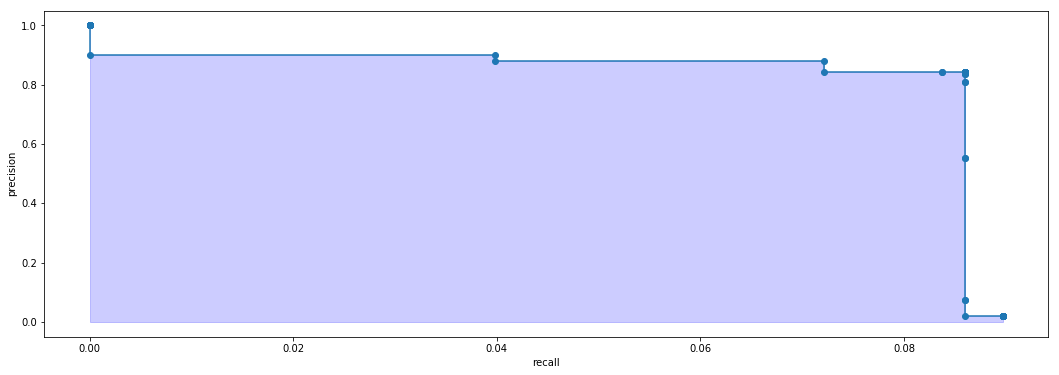

In [15]:
fig, axes = plt.subplots(1,1,figsize=(18,6))
axes.step(recall,precision,'-o',where='post')
axes.fill_between(recall, precision, step='post',alpha=0.2,color='b')
axes.set_xlabel('recall')
axes.set_ylabel('precision')

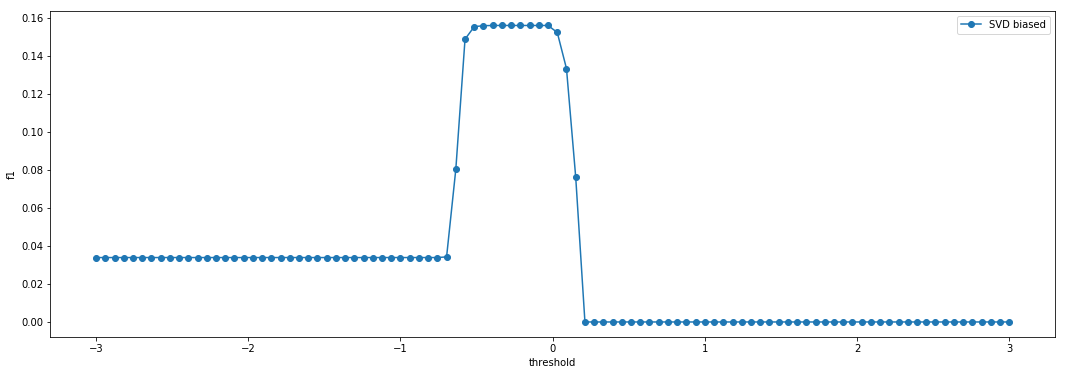

In [16]:
fig, axes = plt.subplots(1,1,figsize=(18,6))
axes.plot(thresholds,f1,'-o', label='SVD biased')
axes.set_xlabel('threshold')
axes.set_ylabel('f1')
axes.legend()